In [16]:
import tensorflow as tf
import numpy as np
import random as rn
import pandas as pd
import os
import csv
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from util_functions import *
# Seed Random Numbers
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)
config = tf.compat.v1.ConfigProto(inter_op_parallelism_threads=1)

from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Conv2D
from tensorflow.keras.layers import Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from dataset_parser import *

import tensorflow.keras.backend as K
tf.random.set_seed(SEED)
K.set_image_data_format('channels_last')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
#config.log_device_placement = True  # to log device placement (on which device the operation ran)

In [11]:
dataset_path = []

for dirname, _, filenames in os.walk('DATA/cicddos2019/'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            dfp = os.path.join(dirname, filename)
            dataset_path.append(dfp)

In [12]:
cols = list(pd.read_parquet(dataset_path[1]))

def load_file(path):
    # data = pd.read_csv(path, sep=',')
    data = pd.read_parquet(path)

    return data

In [13]:
samples = pd.concat([load_file(dfp) for dfp in dataset_path], ignore_index=True)

In [14]:
samples.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

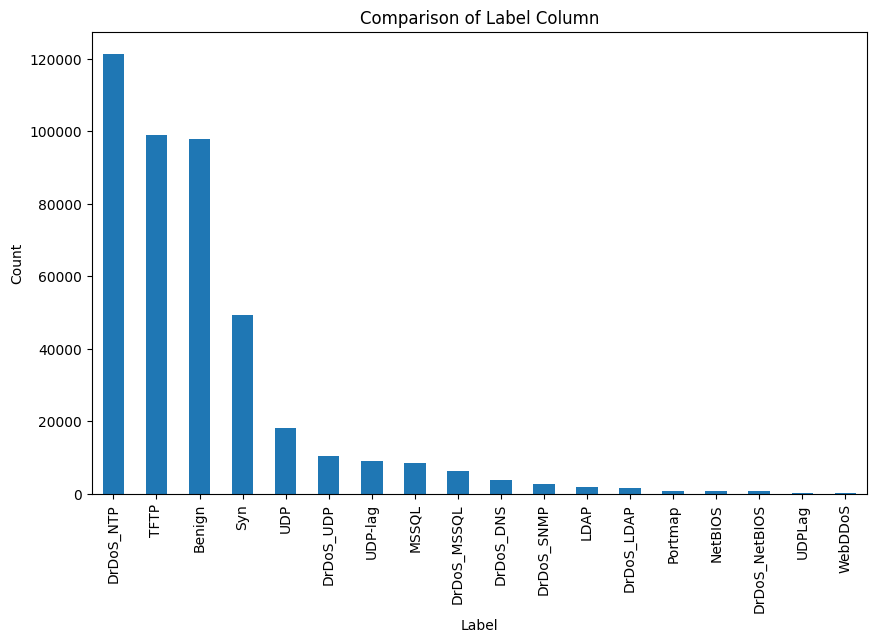

In [ ]:
label_counts = samples['Label'].value_counts()

# Create a bar plot to visualize the label counts
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Comparison of Label Column')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [3]:
dataset_folder = "DATA/cicddos2019"

In [4]:
X_train, Y_train = load_dataset(dataset_folder + "/*" + '-train.hdf5')
X_val, Y_val = load_dataset(dataset_folder + "/*" + '-val.hdf5')

X_train, Y_train = shuffle(X_train, Y_train, random_state=SEED)
X_val, Y_val = shuffle(X_val, Y_val, random_state=SEED)

DATA/cicddos2019/*-train.hdf5
DATA/cicddos2019/10t-10n-DOS2019-dataset-train.hdf5
DATA/cicddos2019/*-val.hdf5
DATA/cicddos2019/10t-10n-DOS2019-dataset-val.hdf5


In [6]:
train_file = glob.glob(dataset_folder + "/*" + '-train.hdf5')[0]
filename = train_file.split('/')[-1].strip()
time_window = int(filename.split('-')[0].strip().replace('t', ''))
max_flow_len = int(filename.split('-')[1].strip().replace('n', ''))
dataset_name = filename.split('-')[2].strip()

In [21]:
print ("\nCurrent dataset folder: ", dataset_folder)


Current dataset folder:  DATA/cicddos2019


In [22]:
model_name = dataset_name + "-nghia"
OUTPUT_FOLDER = "checkpoints/"

In [23]:
# hyperparameters
PATIENCE = 10
DEFAULT_EPOCHS = 1000
VAL_HEADER = ['Model', 'Samples', 'Accuracy', 'F1Score', 'Hyper-parameters','Validation Set']
hyperparamters = {
    "learning_rate": [0.1,0.01],
    "batch_size": [1024,2048],
    "kernels": [32,64],
    "regularization" : [None,'l1'],
    "dropout" : [None,0.2]
}
cross_validation = 1

In [34]:
def Conv2DModel(model_name,input_shape,kernel_col, kernels=64,kernel_rows=3,learning_rate=0.01,regularization=None,dropout=None):
    K.clear_session()

    model = Sequential(name=model_name)
    regularizer = regularization

    model.add(
        Conv2D(
            kernels, 
            (kernel_rows,kernel_col), 
            strides=(1, 1), 
            input_shape=input_shape, 
            kernel_regularizer=regularizer, 
            name='conv0'
        )
    )
    if dropout != None and type(dropout) == float:
        model.add(Dropout(dropout))
    model.add(Activation('relu'))

    model.add(GlobalMaxPooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid', name='fc1'))

    model = compileModel(model, learning_rate, deep=True)
    return model

In [35]:
def compileModel(model,lr,deep=True):
    # optimizer = SGD(learning_rate=lr, momentum=0.0, decay=0.0, nesterov=False)
    optimizer = Adam(
      learning_rate=lr, 
      beta_1=0.9, 
      beta_2=0.999, 
      epsilon=None, 
      decay=0.0, 
      amsgrad=False
    )
    model.compile(
      loss='binary_crossentropy', 
      optimizer=optimizer,metrics=['accuracy']
    )  # here we specify the loss function
    
    print('Model Compiled and Trained')
    return model

In [36]:
keras_classifier = KerasClassifier(
    build_fn=Conv2DModel,
    model_name=model_name, 
    input_shape=X_train.shape[1:],
    kernel_col=X_train.shape[2]
)
rnd_search_cv = GridSearchCV(
    keras_classifier, 
    hyperparamters, 
    cv=cross_validation if cross_validation > 1 else [(slice(None), slice(None))], 
    refit=True, return_train_score=True
)

es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=PATIENCE
)
best_model_filename = OUTPUT_FOLDER + str(time_window) + 't-' + str(max_flow_len) + 'n-' + model_name
mc = ModelCheckpoint(
    best_model_filename + '.h5', 
    monitor='val_accuracy', 
    mode='max', 
    verbose=1, 
    save_best_only=True
)
 
# With K-Fold cross-validation, the validation set is only used for early stopping
rnd_search_cv.fit(
    X_train, 
    Y_train, 
    epochs=DEFAULT_EPOCHS, 
    validation_data=(X_val, Y_val), 
    callbacks=[es, mc]
)

/tmp/ipykernel_141563/726952693.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  keras_classifier = KerasClassifier(


Model Compiled and Trained
Epoch 1/1000
1/4 [======>.......................] - ETA: 1s - loss: 0.6867 - accuracy: 0.4971
Epoch 00001: val_accuracy improved from -inf to 0.84069, saving model to checkpoints/10t-10n-DOS2019-nghia.h5
4/4 [==============================] - 1s 65ms/step - loss: 0.6207 - accuracy: 0.5696 - val_loss: 0.5081 - val_accuracy: 0.8407
Epoch 2/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.5015 - accuracy: 0.8164
Epoch 00002: val_accuracy did not improve from 0.84069
4/4 [==============================] - 0s 14ms/step - loss: 0.4812 - accuracy: 0.7792 - val_loss: 0.4685 - val_accuracy: 0.7475
Epoch 3/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.4852 - accuracy: 0.7197
Epoch 00003: val_accuracy did not improve from 0.84069
4/4 [==============================] - 0s 15ms/step - loss: 0.4399 - accuracy: 0.7989 - val_loss: 0.4052 - val_accuracy: 0.7990
Epoch 4/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.4301 - accuracy: 

In [42]:
best_model = rnd_search_cv.best_estimator_.model

In [43]:
best_model.save(best_model_filename + '.h5')

In [44]:
Y_pred_val = (best_model.predict(X_val) > 0.5)
Y_true_val = Y_val.reshape((Y_val.shape[0], 1))
f1_score_val = f1_score(Y_true_val, Y_pred_val)
accuracy = accuracy_score(Y_true_val, Y_pred_val)

In [46]:
val_file = open('output.csv', 'w', newline='')
val_file.truncate(0)  # clean the file content (as we open the file in append mode)
val_writer = csv.DictWriter(val_file, fieldnames=VAL_HEADER)
val_writer.writeheader()
val_file.flush()
row = {'Model': model_name, 'Samples': Y_pred_val.shape[0], 'Accuracy': '{:05.4f}'.format(accuracy), 'F1Score': '{:05.4f}'.format(f1_score_val),
        'Hyper-parameters': rnd_search_cv.best_params_, "Validation Set": glob.glob(dataset_folder + "/*" + '-val.hdf5')[0]}
val_writer.writerow(row)
val_file.close()

In [47]:
print("Best parameters: ", rnd_search_cv.best_params_)
print("Best model path: ", best_model_filename)
print("F1 Score of the best model on the validation set: ", f1_score_val)

Best parameters:  {'batch_size': 1024, 'dropout': None, 'kernels': 32, 'learning_rate': 0.1, 'regularization': None}
Best model path:  checkpoints/10t-10n-DOS2019-nghia
F1 Score of the best model on the validation set:  0.997690531177829


In [48]:
# Evaluate the model on the training set
train_loss, train_accuracy = best_model.evaluate(X_train, Y_train, verbose=0)

# Evaluate the model on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val, Y_val, verbose=0)

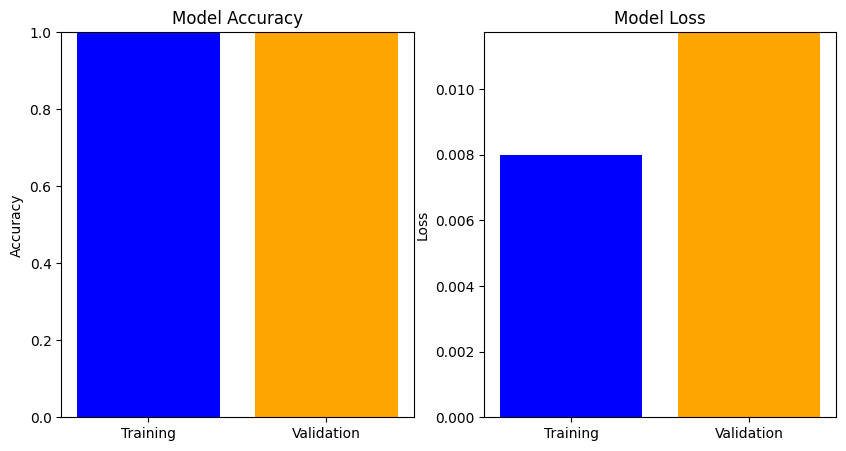

In [49]:
import matplotlib.pyplot as plt

# Data for plotting
categories = ['Training', 'Validation']
accuracy = [train_accuracy, val_accuracy]
loss = [train_loss, val_loss]

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(categories, accuracy, color=['blue', 'orange'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

# Plotting Loss
plt.subplot(1, 2, 2)
plt.bar(categories, loss, color=['blue', 'orange'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.ylim([0, max(train_loss, val_loss)])

plt.show()
